# DAE multiple shooting solution

*Originally created by Joel Andersson in 2015*

In this notebook we seek to solve the optimal control problem (OCP) given by

$$
\min\int_{0}^{10}x_0^2+x_1^2+u^2dt
$$

subjected to

\begin{align*}
\dot{x}_0 &= zx_0-x_1+u & \quad{}t\in[0,10]\\
\dot{x}_1 &= x_0        & \quad{}t\in[0,10]\\
0         &= x_1^2+z-1  & \quad{}t\in[0,10]
\end{align*}

with boundary values

\begin{align*}
x_0(t=0) &= 0\\
x_1(t=0) &= 1\\
x_0(t=10) &= 0\\
x_1(t=10) &= 0
\end{align*}

and bounded control $u\in[-0.75;1.00]$ over the whole interval, with $z$ being an algebraic variable.

An alternate implementation and description of this problem is provided with [Dymos](https://openmdao.github.io/dymos/examples/vanderpol/vanderpol.html) package.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]

We start by importing all required tool explicitly.

In [2]:
from casadi import inf
from casadi import integrator
from casadi import nlpsol
from casadi import linspace
from casadi import vertcat
from casadi import MX
from casadi import SX
import matplotlib.pyplot as plt

The problem is build on `SX` symbolics defined as follows:

In [3]:
x0 = SX.sym("x0")
x1 = SX.sym("x1")

z = SX.sym("z")
u = SX.sym("u")

The different problem equations can then be written as:

In [4]:
# Lagrange cost term (quadrature)
quad = x0**2 + x1**2 + u**2

# Differential equation
ode = vertcat(
    z * x0 - x1 + u,
    x0
)

# Algebraic equation
alg = x1**2 + z - 1

Time integration parameters are then declared:

In [5]:
# Number of intervals.
nk = 50

# Final time [s].
tend = 10.0

# Time step [s].
tf = tend / nk

To provide `x` to integrator we need to have it as a state vector, which can be compiled by concatenating the states `x0` and `x1` using `vertcat`. Below we use the interface to [Sundials IDAS](https://computing.llnl.gov/projects/sundials/idas) to provide DAE time-stepping later in multiple shooting. The value of `tf` in the `opts` dictionary provide the integration time step.

In [6]:
dae = {
    "x": vertcat(x0, x1),
    "z": z,
    "p": u,
    "ode": ode,
    "alg": alg,
    "quad": quad
}

opts = {"tf": tf}

I = integrator("I", "idas", dae, opts)

To differentiate the variables from DAE to those of multiple shooting NLP, we will use `w` in what follows. Below we initialize arrays for variables, bounds, constraints, and the value of cost function. These will be used to build the NLP.

In [7]:
# List of variables
w = []

# Lower bounds on w
lbw = []

# Upper bounds on w
ubw = []

# Constraints
g = []

# Cost function
f = 0.0

For multiple shooting we use `MX` symbolics. For enforcing initial state in NPL we create a first state `Xk` and enforce its lower and upper bounds (`lbw` and `ubw`) to match the values given in problem statement.

In [8]:
Xk = MX.sym("X0", 2)

w.append(Xk)
lbw.extend([0.0, 1.0])
ubw.extend([0.0, 1.0])

The idea behind multiple shooting integration loop is quite simple:

1. we create a local control $u_k$ to integrate over $t_k$ to $t_{k+1}$, which is a free variable in NLP problem, thus it must be added to `w` and its bounds to `lbw` and `ubw`,

1. then we call the DAE integrator to retrieve (symbolically here) the state and lagrangian quadradure that is produced with control $u_k$ and current problem state $x_k$,

1. perform variable *lifting*, *i.e.* we store predicted state and create a new symbolic state which is now a free variable and must again be added to `w` and its bounds to `lbw` and `ubw`,

1. finally we constrain the created state to match the previous prediction in `g`, what is the *shooting* part of the integration.

In [9]:
for k in range(nk):
    # Local control
    Uk = MX.sym(f"U{k}")
    w.append(Uk)
    lbw.append(-0.75)
    ubw.append( 1.00)

    # Call integrator function
    Ik = I(x0=Xk, p=Uk)
    Xk = Ik["xf"]
    f += Ik["qf"]

    # "Lift" the variable
    X_prev = Xk

    # Create new symbolic state
    Xk = MX.sym(f"X{k+1}", 2)
    w.append(Xk)
    lbw.extend([-inf, -inf])
    ubw.extend([+inf, +inf])

    # Constrain problem
    g.append(X_prev - Xk)

To solve the problem we allocate an NLP solver. Notice that the interface of `nlpsol` is quite similar to the one of `integrator`. Here we make use of [Ipopt](https://github.com/coin-or/Ipopt) to perform optimization. Below we can inspect the interface of the function created by the wrapper.

In [10]:
nlp = {
    "x": vertcat(*w),
    "f": f,
    "g": vertcat(*g)
}

opts = {
    "ipopt.print_level": 3,
    "ipopt.linear_solver": "mumps",
    # "ipopt.output_file": "ipopt.txt"
}

solver = nlpsol("solver", "ipopt", nlp, opts)
solver

Function(solver:(x0[152],p[],lbx[152],ubx[152],lbg[100],ubg[100],lam_x0[152],lam_g0[100])->(x[152],f,g[100],lam_x[152],lam_g[100],lam_p[]) IpoptInterface)

To solve the NLP we provide an initial guess, the bounds of free variables and the ones of constraints (`lbg and `ubg`. Notice that you could provide constraint relaxation in some cases as allowed by specific problems.

In [11]:
sol = solver(x0=0.0, lbx=lbw, ubx=ubw, lbg=0.0, ubg=0.0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      150
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 11

     

Below you can inspect the keys in solution dictionary. We are looking for `x` here. Since the constraint violation in the report above is acceptable, we can skip the detailed inspection of `g` residuals. You can also check the value of cost `f`.

In [12]:
sol.keys()

dict_keys(['f', 'g', 'lam_g', 'lam_p', 'lam_x', 'x'])

Since when creating free variables vector `w` we started by initial states before entering the loop to add controls and following states, we have that starting on index 0 the variables correspond to $x_0$, index 1 to $x_1$, and index 2 to $u$. Since there are three variables, we recover then every 3 elements using slicing syntax.

*Note:* by calling method `full()` we convert CasADi `DM` numerical array to plain Numpy. Since this will produce one dimension per element, it is usefull to call `ravel()` and get an one-dimensional array.

In [13]:
xs = sol["x"].full().ravel()

x0 = xs[0::3]
x1 = xs[1::3]
us = xs[2::3]

Because we have an initial state, there are `nk+1` states and `nk` control intervals. To proper represent them graphically we allocate corresponding time arrays.

In [14]:
tx = linspace(0.0, tend, nk + 1).full()
tu = linspace(0.0, tend, nk + 0).full()

Finally the full solution can be visualized. Since controls are held constant over intervals, a step representation is more adapted for this variable.

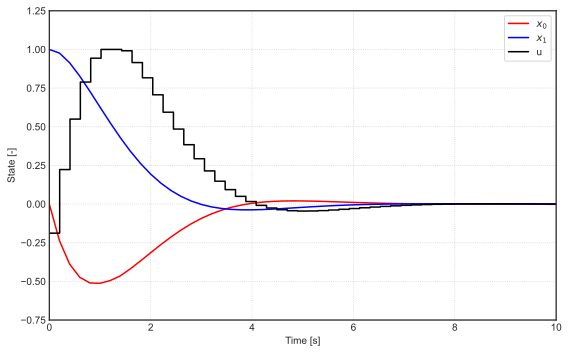

In [15]:
plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(8, 5))

plt.plot(tx, x0, "r", label="$x_0$")
plt.plot(tx, x1, "b", label="$x_1$")
plt.step(tu, us, "k", label="u", where="post")
plt.grid(linestyle=":")

plt.xlim(0, tend)
plt.ylim(-0.75, 1.25)

plt.xlabel("Time [s]")
plt.ylabel("State [-]")

plt.legend(loc="upper right", frameon=True)
plt.tight_layout()